## Calculating the frequency of irrigated cropping as a proxy for intensity

Script is divided into two sections:

1. The first part creates a large rasterstack of all the irrigated area files and exports it as netcdf.
2. The rasterstack is then loaded as an xarray object and per-pixel frequency is calculated.

This script is for testing.  To run this at scale use croppingFrequency.py on hugemem

A second part of this script creates a commission error mask using the results of the cropping frequency code

In [ ]:
import sys
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
# sys.path.append('src')
# import DEAPlotting, SpatialTools

### User Inputs

In [ ]:
results = "results/nmdb_plots/frequency/"

### Part 1: Create rasterstack of irrigation 

Too large to run on the VDI

In [ ]:
#list of years to help for-loop iterate through folders
x = range(1987,2019,1)
years = []
for i in x:
    nextyear = str(i + 1)[2:]
    y = str(i) + "_" + nextyear
    years.append(str(y))
# removing years that didn't work
years =  [e for e in years if e not in ('2011_12', '2012_13')]
years.sort()

#list of folders to help with loop
folders = os.listdir(directory)
folders.sort()

# Convert our shapefiles into tiffs, add them to an giant xarray and 
# then export as netcdf 
def convertIrrShpToTiff(shp, year):  
    #open a tif and get transform info
    tif = shp[:77]+shp[77:95]+"_multithreshold_65Thres"+suffix[10:]+".tif"
    ds = xr.open_rasterio(tif).squeeze()
    transform, proj = geotransform(ds, (ds.x, ds.y), epsg=3577)
    rows,cols = ds.shape
    #turn vector into numpy array
    shp_arr = rasterize_vector(shp, cols=cols, rows=rows, geo_transform=transform, projection=proj)
    #convert numpy array into xarray
    shp_xr = xr.DataArray(shp_arr, coords = [ds.y, ds.x], dims = ['y', 'x'])
    #append xarray to list
    da_list.append(shp_xr)

da_list = []
for year, folder in zip(years, folders): 
    print("\r", "working on year: " + year, end = '')
    convertIrrShpToTiff(directory+folder+"/"+"nmdb_Summer"+ year + suffix+".shp", year)

#generate date ranges to use as coordinates in xrray dataset
dates = pd.date_range(start='1/1/1987', end='1/01/2019', freq='Y')
dates = dates.drop([pd.Timestamp('2011-12-31'), pd.Timestamp('2012-12-31')])
#concatenate all xarrays into a single multi-dim xarray with time ('dates') as coords.
da = xr.concat(da_list, dim=dates).rename({'concat_dim':'time'}).rename('Irrigated_Area')
#convert to dataset
ds = da.to_dataset()
#export as netcdf
ds.to_netcdf(results + "NMDB_irrigation.nc")

### Part 2: Calculate per pixel frequency et al.

Testing the workflow on a small area then running on hugemem using the .py file of the same name

In [1]:
print("hfd")

hfd


In [2]:
import xarray as xr
import numpy as np

In [3]:
z = xr.open_dataset('results/NMDB_irrigation.nc').isel(x=range(26000,28000)).isel(y=range(18500,20000))

In [14]:
z

<xarray.Dataset>
Dimensions:         (time: 30, x: 2000, y: 1500)
Coordinates:
  * time            (time) datetime64[ns] 1987-12-31 1988-12-31 ... 2018-12-31
  * y               (y) float64 -3.205e+06 -3.205e+06 ... -3.243e+06 -3.243e+06
  * x               (x) float64 1.504e+06 1.504e+06 ... 1.554e+06 1.554e+06
Data variables:
    Irrigated_Area  (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    transform:   [ 2.5000e+01  0.0000e+00  8.5395e+05  0.0000e+00 -2.5000e+01...
    crs:         +init=epsg:3577
    res:         [25. 25.]
    is_tiled:    1
    nodatavals:  0.0
    scales:      1.0
    offsets:     0.0

In [6]:
#create parallized function for calculating sum on the array
def count_irrigation(x, dim):
    return xr.apply_ufunc(np.sum, x, dask='parallelized',
                          input_core_dims=[[dim]],
                          kwargs={'axis': -1})

count = count_irrigation(z.Irrigated_Area, dim='time')
rawfrequency = count / len(z.time)

In [7]:
def IrrigationFirstOccurs(x, dim):
    """
    Calculating the time (indice) at which the first occurence of 
    Irrigation occurs (per-pixel). This works because np.nanargmax:
    "In cases of multiple occurrences of the maximum values,
    the indices corresponding to the first occurrence are returned."
    """
    return xr.apply_ufunc(np.nanargmax, x, dask='parallelized',
                          input_core_dims=[[dim]],
                          kwargs={'axis': -1})

firstOccured = IrrigationFirstOccurs(z, dim='time')
yearsIrrigated = len(z.time) - firstOccured 
normalisedFrequency = count / yearsIrrigated

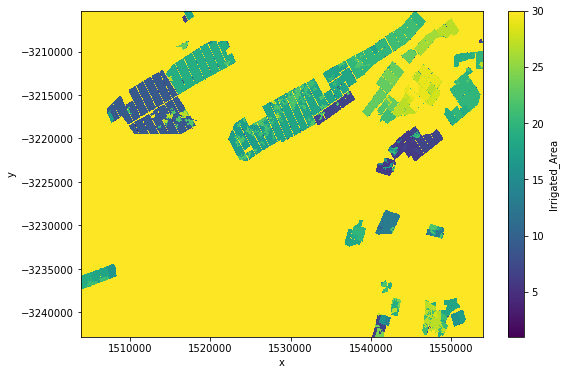

In [13]:
yearsIrrigated.Irrigated_Area.plot(size=6)

In [11]:
#covert first observed to an array with the date (year)
dates = [t for t in range(1987,2019,1)]
dates =  [e for e in dates if e not in (2011, 2012)]
dates = np.asarray(dates)

def timey(ind, time):
    func = time[ind]
    return func

firstOccuredDates = timey(firstOccured.Irrigated_Area, dates)

In [12]:
firstOccuredDates.plot(size=6)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [ ]:
# rawfrequency.where(frequency >= 0.01).plot(figsize=(5,5), cmap='plasma')

In [ ]:
# yearsIrrigated.Irrigated_Area.plot(figsize=(5,5), cmap='plasma')

In [ ]:
# normalisedFrequency.Irrigated_Area.plot(figsize=(8,8), cmap='plasma')

## Generate commission error mask

Commission masking using per-pixel frequency maps:
-	If normalised frequency (all_time) is <=0.125 (1 in 8 years) == commision error
-	Relax that threshold to account for recent commission errors (whose normalised frequency will look like higher frequency cropping.) If the count is equal to 1 and the normalised frequency is between 0.125 and 0.25, count as commission error.
-	Commission errors occurring for the first time in the last 3 years (since 2016) will be missed by this analysis. Regions converted to irrigation between 2010 and 2015 that were only irrigated once will be erroneously recorded as commission errors. 
-	Regions that were irrigated for a short period of time (low count) at the start of the time-series, but then underwent land use change and were no longer irrigated, will be erroneously removed by the commission masks. Eg. Imagine a paddock first irrigated in 1988 and irrigated for 3 years before ceasing being irrigatedits normalised frequency will be 3/29=0.103 and thus it will be removed by the commission error mask (set at 0.125)


In [ ]:
#open files
freq = xr.open_rasterio(results+'normalisedFrequency_alltime.tif').isel(x=range(26000,28000)).isel(y=range(18500,20000)).squeeze()
count = xr.open_rasterio(results+'count_alltime.tif').isel(x=range(26000,28000)).isel(y=range(18500,20000)).squeeze()

In [ ]:
freq_mask = np.where((freq.values <= 0.125) & (freq.values > 0), 1, 0)
# plt.figure(figsize=(15,15))
# plt.imshow(freq_mask)

In [ ]:
count_mask = np.where((count.values == 1) & ((freq.values > 0.125) & (freq.values <= 0.25)), 1, 0)

In [ ]:
combined_mask = np.where((freq_mask==1) | (count_mask==1), 1, 0)

In [ ]:
transform, projection = SpatialTools.geotransform(freq, (freq.x, freq.y), epsg=3577)
SpatialTools.array_to_geotiff(results+ "commission_mask.tif",
              combined_mask, geo_transform = transform, 
              projection = projection, 
              nodata_val=0)